## 2 Data Understanding
### 2.3.1 Preparation before exploring data


In [7]:
# !python install imbalanced-learn
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
import pandas as pd
from pyspark.sql import *
spark = SparkSession.builder.appName('Data_Understanding').getOrCreate()
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.types import StructType, StructField, IntegerType

#### 1.read data from datasource

In [8]:
pandasDF = pd.read_csv('/home/ubuntu/BDAS_yang124/Datasets/College.csv')
sparkDF = spark.createDataFrame(pandasDF)

View the data as a whole

In [9]:
sparkDF.printSchema()
sparkDF.show(8)
sparkDF.columns

root
 |-- CN: string (nullable = true)
 |-- Private: string (nullable = true)
 |-- Apps: long (nullable = true)
 |-- Accept: long (nullable = true)
 |-- Enroll: long (nullable = true)
 |-- Top10perc: long (nullable = true)
 |-- Top25perc: long (nullable = true)
 |-- F.Undergrad: long (nullable = true)
 |-- P.Undergrad: long (nullable = true)
 |-- Outstate: long (nullable = true)
 |-- Room.Board: long (nullable = true)
 |-- Books: long (nullable = true)
 |-- Personal: long (nullable = true)
 |-- PhD: long (nullable = true)
 |-- Terminal: long (nullable = true)
 |-- S.F.Ratio: double (nullable = true)
 |-- perc.alumni: long (nullable = true)
 |-- Expend: long (nullable = true)
 |-- Grad.Rate: long (nullable = true)

+--------------------+-------+----+------+------+---------+---------+-----------+-----------+--------+----------+-----+--------+---+--------+---------+-----------+------+---------+
|                  CN|Private|Apps|Accept|Enroll|Top10perc|Top25perc|F.Undergrad|P.Undergrad|Ou

['CN',
 'Private',
 'Apps',
 'Accept',
 'Enroll',
 'Top10perc',
 'Top25perc',
 'F.Undergrad',
 'P.Undergrad',
 'Outstate',
 'Room.Board',
 'Books',
 'Personal',
 'PhD',
 'Terminal',
 'S.F.Ratio',
 'perc.alumni',
 'Expend',
 'Grad.Rate']

#### 1.The CN field is removed because it does not have an analysis feature

In [10]:
remove_cn_DF = sparkDF.selectExpr(
 'Private',
 'Apps',
 'Accept',
 'Enroll',
 'Top10perc',
 'Top25perc',
 "`F.Undergrad` as F_Undergrad",
 "`P.Undergrad` as P_Undergrad",
 'Outstate',
 "`Room.Board` as Room_Board",
 'Books',
 'Personal',
 'PhD',
 'Terminal',
 "`S.F.Ratio` as S_F_Ratio",
 "`perc.alumni` as perc_alumi",
 'Expend',
"`Grad.Rate` as Grad_Rate" )
pandas_cols=[
    'CN',
    'Private',
    'Apps',
 'Accept',
 'Enroll',
 'Top10perc',
 'Top25perc',
 'F_Undergrad',
 'P_Undergrad',
 'Outstate',
 'Room_Board',
 'Books',
 'Personal',
 'PhD',
 'Terminal',
 'S_F_Ratio',
 'perc_alumi',
 'Expend',
 'Grad_Rate']
pandasDF.columns = pandas_cols


In [11]:
remove_cn_DF.printSchema()
remove_cn_DF.describe().show()
remove_cn_DF.show(8)
remove_cn_DF.columns

root
 |-- Private: string (nullable = true)
 |-- Apps: long (nullable = true)
 |-- Accept: long (nullable = true)
 |-- Enroll: long (nullable = true)
 |-- Top10perc: long (nullable = true)
 |-- Top25perc: long (nullable = true)
 |-- F_Undergrad: long (nullable = true)
 |-- P_Undergrad: long (nullable = true)
 |-- Outstate: long (nullable = true)
 |-- Room_Board: long (nullable = true)
 |-- Books: long (nullable = true)
 |-- Personal: long (nullable = true)
 |-- PhD: long (nullable = true)
 |-- Terminal: long (nullable = true)
 |-- S_F_Ratio: double (nullable = true)
 |-- perc_alumi: long (nullable = true)
 |-- Expend: long (nullable = true)
 |-- Grad_Rate: long (nullable = true)

+-------+-------+------------------+------------------+----------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------

['Private',
 'Apps',
 'Accept',
 'Enroll',
 'Top10perc',
 'Top25perc',
 'F_Undergrad',
 'P_Undergrad',
 'Outstate',
 'Room_Board',
 'Books',
 'Personal',
 'PhD',
 'Terminal',
 'S_F_Ratio',
 'perc_alumi',
 'Expend',
 'Grad_Rate']

#### 2.Remove elements with empty Private fields

In [12]:
remove_Null_Private_DF = remove_cn_DF.filter('Private is not null')
remove_Null_Private_DF.printSchema()
remove_Null_Private_DF.describe().show()

root
 |-- Private: string (nullable = true)
 |-- Apps: long (nullable = true)
 |-- Accept: long (nullable = true)
 |-- Enroll: long (nullable = true)
 |-- Top10perc: long (nullable = true)
 |-- Top25perc: long (nullable = true)
 |-- F_Undergrad: long (nullable = true)
 |-- P_Undergrad: long (nullable = true)
 |-- Outstate: long (nullable = true)
 |-- Room_Board: long (nullable = true)
 |-- Books: long (nullable = true)
 |-- Personal: long (nullable = true)
 |-- PhD: long (nullable = true)
 |-- Terminal: long (nullable = true)
 |-- S_F_Ratio: double (nullable = true)
 |-- perc_alumi: long (nullable = true)
 |-- Expend: long (nullable = true)
 |-- Grad_Rate: long (nullable = true)

+-------+-------+------------------+------------------+----------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------

将private 转换为int类型

In [13]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
inputCols=['Apps',
 'Accept',
 'Enroll',
 'Top10perc',
 'Top25perc',
 'F_Undergrad',
 'P_Undergrad',
 'Outstate',
 'Room_Board',
 'Books',
 'Personal',
 'PhD',
 'Terminal',
 'S_F_Ratio',
 'perc_alumi',
 'Expend',
 'Grad_Rate']
assembler = VectorAssembler(
  inputCols=inputCols,
outputCol="features")
output = assembler.transform(remove_Null_Private_DF)
indexer = StringIndexer(inputCol="Private", outputCol="PrivateIndex")
privateIndex_fixed_DF = indexer.fit(output).transform(output)

 ### 2.3.2 check data
 #### 1.check data balance

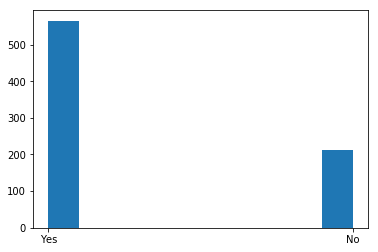

In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Convert sex to an array using Numpy and plot it using pyplot. 
publ = np.array(privateIndex_fixed_DF.select('Private').collect())
plt.hist(publ)
plt.show()

分割数据

In [15]:
final_data = privateIndex_fixed_DF.select("features",'PrivateIndex')
train_data,test_data = final_data.randomSplit([0.7,0.3])

数据基于Private字段进行过采样

In [16]:
# import pandas 
# from imblearn.over_sampling import SMOTE
# smo = SMOTE(random_state=42)
# columns = output_fixed.columns
# pridata=output_fixed.select('PrivateIndex')
# X_smo, y_smo = smo.fit_sample(output_fixed, pridata)
# x_smote_resampled = pandas.DataFrame(X_smo,columns=columns)
# print(x_smote_resampled)
# # def getRendomCsvdata(DataDF,pridata):
    
# #     columns = ['Private','Apps','Accept','Enroll','Top10perc','Top25perc','F.Undergrad','P.Undergrad','Outstate','Room.Board','Books','Personal','PhD','Terminal','S.F.Ratio','perc.alumni','Expend','Grad.Rate']
 
    
# #     return x_smote_resampled

# # def dataBanlance(DataDF,filename):
    
# #     DataDF = getRendomCsvdata(DataDF, pridata)
# #     DataDF.to_csv(filename,index=None)
# #     return DataDF

#### 2.check data importances

 1) F_Undergrad                    0.233030
 2) Outstate                       0.212766
 3) Enroll                         0.126533
 4) P_Undergrad                    0.091084
 5) S_F_Ratio                      0.066570
 6) Room_Board                     0.063968
 7) Accept                         0.061960
 8) Expend                         0.025940
 9) perc_alumi                     0.021990
10) Apps                           0.021269
11) Grad_Rate                      0.019119
12) PhD                            0.016593
13) Terminal                       0.012991
14) Personal                       0.008729
15) Top10perc                      0.008222
16) Top25perc                      0.006494
17) Books                          0.002742


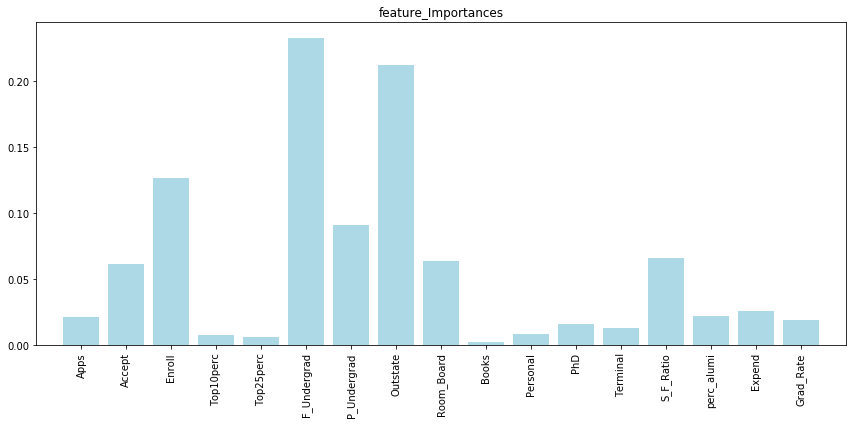

In [18]:
from pyspark.ml.classification import RandomForestClassifier

rfc = RandomForestClassifier(labelCol='PrivateIndex',featuresCol='features')
rfc_model = rfc.fit(train_data)
feature_Importances=rfc_model.featureImportances
sort_index=np.argsort(feature_Importances)[::-1]

sort_index=sort_index.tolist()
for f in sort_index:
    print("%2d) %-*s %f" % (sort_index.index(f)+1,30,inputCols[f],feature_Importances[f]))
plt.figure(figsize=(12,6))
plt.title("feature_Importances")
plt.bar(inputCols,
       feature_Importances,
        color="lightblue",
        align="center"
       )
plt.xticks(range(17),inputCols,rotation='vertical')
plt.xlim([-1,17])
plt.tight_layout()
plt.show()

#### 3.fields skewness check

            rows classCnt mostClassCnt mostClassRio
Apps         777        4          743     0.956242
Accept       777        4          734     0.944659
Enroll       777        4          677       0.8713
Top10perc    777        4          411     0.528958
Top25perc    777        4           87     0.111969
F_Undergrad  777        4          675     0.868726
P_Undergrad  777        4          764     0.983269
Outstate     777        4          186     0.239382
Room_Board   777        4          140      0.18018
Books        777        4          668     0.859717
Personal     777        4          633     0.814672
PhD          777        4           11     0.014157
Terminal     777        4           14     0.018018
S_F_Ratio    777        4          225     0.289575
perc_alumi   777        4          286     0.368082
Expend       777        4          724     0.931789
Grad_Rate    777        4           44    0.0566281


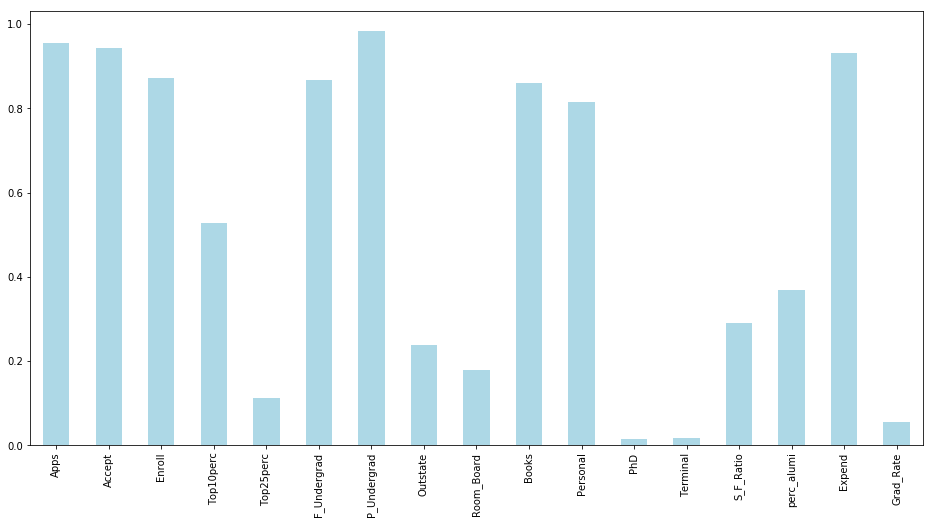

In [19]:

new_DF = pandasDF.drop(['CN','Private'],axis=1)
new_df2 = new_DF[pandas_cols[2:len(pandas_cols)]]

skewDf2 = pd.DataFrame(index=new_DF.columns.values,columns=['rows','classCnt','mostClassCnt','mostClassRio'])
m2,n2 = new_df2.shape
for j in range(n2):
    ser = new_df2.iloc[:,j]
    name = new_df2.columns[j]
    freqSer = pd.value_counts(pd.cut(ser,4))
    skewDf2.loc[name,'rows'] = m2
    skewDf2.loc[name,'classCnt'] = len(freqSer)
    skewDf2.loc[name,'mostClassCnt'] = freqSer[0] 
    skewDf2.loc[name,'mostClassRio'] = freqSer[0] * 1.00 / m2
skewDf = pd.concat([skewDf2],axis=0)
print(skewDf)
skewDf_mostClassRio=skewDf['mostClassRio']
skewDf_mostClassRio.plot(kind='bar',figsize=(16,8), color='lightblue')

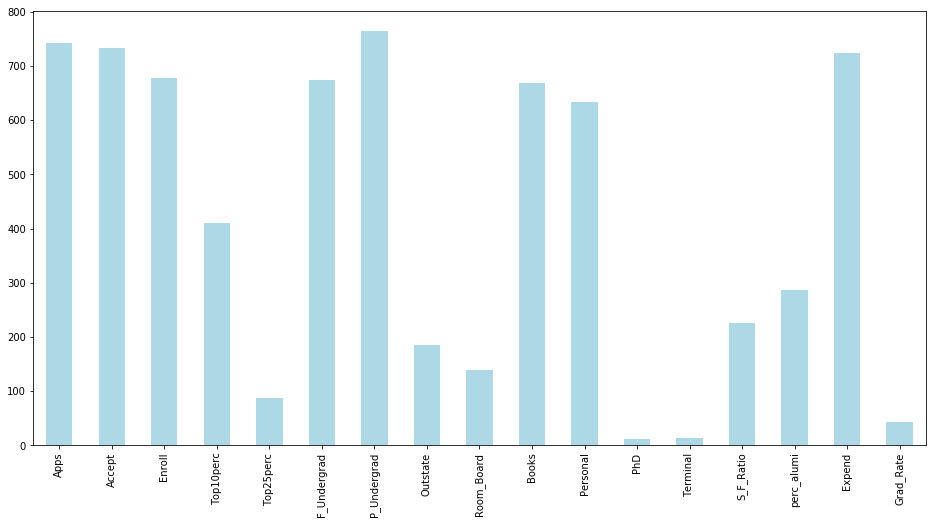

In [20]:
skewDf_mostClassCnt=skewDf['mostClassCnt']
skewDf_mostClassCnt.plot(kind='bar',figsize=(16,8), color='lightblue')

### 2.4Verify The Data Quality
#### 1.verify data null value

             rows  nullCnt
Apps          777        0
Accept        777        0
Enroll        777        0
Top10perc     777        0
Top25perc     777        0
F_Undergrad   777        0
P_Undergrad   777        0
Outstate      777        0
Room_Board    777        0
Books         777        0
Personal      777        0
PhD           777        0
Terminal      777        0
S_F_Ratio     777        0
perc_alumi    777        0
Expend        777        0
Grad_Rate     777        0


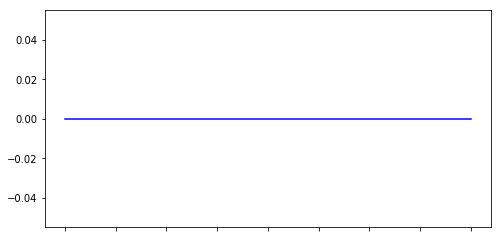

In [41]:
m,n = new_DF.shape
rowsSer = pd.Series(index=new_DF.columns)
rowsSer.name = 'rows'
nullCntSer = new_DF.isnull().sum()
nullCntSer.name = 'nullCnt'
missDf = pd.concat([rowsSer,nullCntSer],axis=1)
missDf['rows'] = m
print(missDf)
missDf['nullCnt'].plot(kind='line',figsize=(8,4),color='blue')

#### 2. verify Field unique number 

             rows  uiqCnt
Apps          777     711
Accept        777     693
Enroll        777     581
Top10perc     777      82
Top25perc     777      89
F_Undergrad   777     714
P_Undergrad   777     566
Outstate      777     640
Room_Board    777     553
Books         777     122
Personal      777     294
PhD           777      78
Terminal      777      65
S_F_Ratio     777     173
perc_alumi    777      61
Expend        777     744
Grad_Rate     777      81


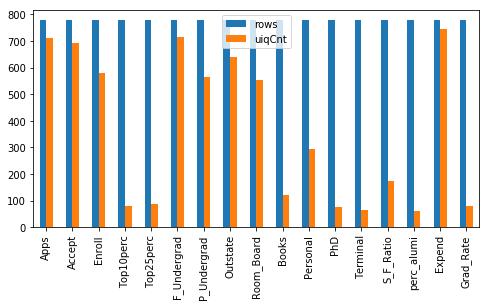

In [21]:
m,n = new_DF.shape
uiqDf = pd.DataFrame(index=new_DF.columns,columns=['rows','uiqCnt'])
uiqDf['rows'] = m
for j in range(n):
    ser = new_DF.iloc[:,j]
    name = new_DF.columns[j]
    uiqCnt = len(ser.unique())
    uiqDf.loc[name, 'uiqCnt'] = uiqCnt
print(uiqDf)
uiqDf.plot(kind='bar',figsize=(8,4))

#### 3.Outlier detection

                 max     min          mean          std       cov  \
Apps         48094.0    81.0   3001.638353  3870.201484  1.289363   
Accept       26330.0    72.0   2018.804376  2451.113971  1.214141   
Enroll        6392.0    35.0    779.972973   929.176190  1.191293   
Top10perc       96.0     1.0     27.558559    17.640364  0.640105   
Top25perc      100.0     9.0     55.796654    19.804778  0.354946   
F_Undergrad  31643.0   139.0   3699.907336  4850.420531  1.310957   
P_Undergrad  21836.0     1.0    855.298584  1522.431887  1.780000   
Outstate     21700.0  2340.0  10440.669241  4023.016484  0.385322   
Room_Board    8124.0  1780.0   4357.526384  1096.696416  0.251679   
Books         2340.0    96.0    549.380952   165.105360  0.300530   
Personal      6800.0   250.0   1340.642214   677.071454  0.505035   
PhD            103.0     8.0     72.660232    16.328155  0.224719   
Terminal       100.0    24.0     79.702703    14.722359  0.184716   
S_F_Ratio       39.8     2.5     1

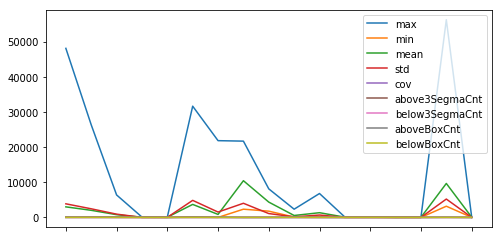

In [43]:

resDf = new_df2.describe()
resDf.loc['cov'] = resDf.loc['std'] / resDf.loc['mean']   
resDf.loc['mean+3std'] = resDf.loc['mean'] + 3 * resDf.loc['std']  
resDf.loc['mean-3std'] = resDf.loc['mean'] - 3 * resDf.loc['std'] 
resDf.loc['75%+1.5dist'] = resDf.loc['75%'] + 1.5 * (resDf.loc['75%'] - resDf.loc['25%'])  
resDf.loc['25%-1.5dist'] = resDf.loc['25%'] - 1.5 * (resDf.loc['75%'] - resDf.loc['25%'])  

segmaSer1 = new_df2[new_df2 > resDf.loc['mean+3std']].count()   
segmaSer1.name = 'above3SegmaCnt'
segmaSer2 = new_df2[new_df2 < resDf.loc['mean-3std']].count()    
segmaSer2.name = 'below3SegmaCnt'

boxSer1 = new_df2[new_df2 > resDf.loc['75%+1.5dist']].count()    
boxSer1.name = 'aboveBoxCnt'
boxSer2 = new_df2[new_df2 < resDf.loc['25%-1.5dist']].count()    
boxSer2.name = 'belowBoxCnt'

outTmpDf1 = pd.concat([segmaSer1,segmaSer2,boxSer1,boxSer2],axis=1)
outTmpDf2 = resDf.loc[['max','min','mean','std','cov']]
outDf = pd.concat([outTmpDf2.T, outTmpDf1], axis=1)
print(outDf)
outDf.plot(kind='line',figsize=(8,4))

#### 4.Normal distribution check

             rows  posCnt  zeroCnt  negCnt
Apps          777     777        0       0
Accept        777     777        0       0
Enroll        777     777        0       0
Top10perc     777     777        0       0
Top25perc     777     777        0       0
F_Undergrad   777     777        0       0
P_Undergrad   777     777        0       0
Outstate      777     777        0       0
Room_Board    777     777        0       0
Books         777     777        0       0
Personal      777     777        0       0
PhD           777     777        0       0
Terminal      777     777        0       0
S_F_Ratio     777     777        0       0
perc_alumi    777     775        2       0
Expend        777     777        0       0
Grad_Rate     777     777        0       0


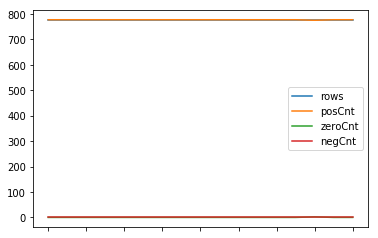

In [44]:

distDf = pd.DataFrame(index=new_DF.columns.values,columns=['rows','posCnt','zeroCnt','negCnt'])
m,n = new_df2.shape
for j in range(n):
    ser = new_df2.iloc[:,j]
    name = new_df2.columns[j]
    posCnt = ser[ser>0].count()
    zeroCnt = ser[ser==0].count()
    negCnt = ser[ser<0].count()
    distDf.loc[name,'rows'] = m
    distDf.loc[name,'posCnt'] = posCnt
    distDf.loc[name,'zeroCnt'] = zeroCnt
    distDf.loc[name, 'negCnt'] = negCnt
print(distDf)
distDf.plot()

#### 5.The normal distribution of the data

/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  app.launch_new_instance()


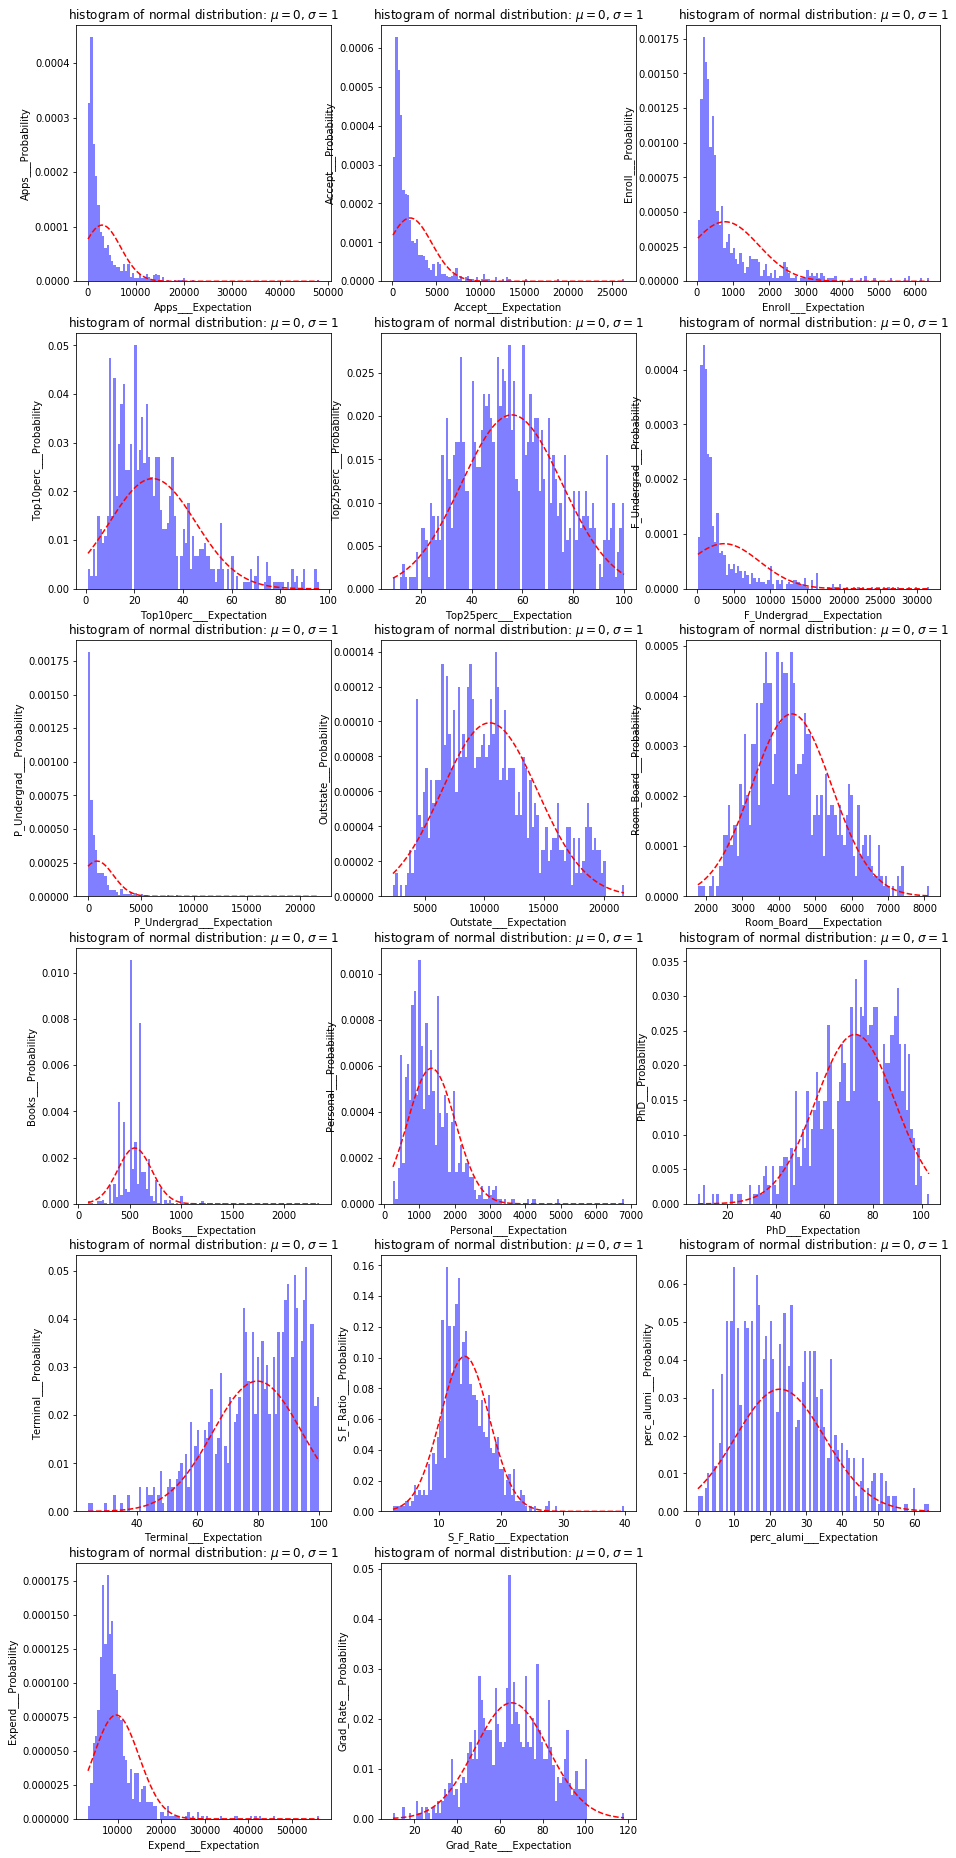

In [45]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

def expectation(df):
    plt.figure(figsize=(16,33))
    i=0
    for subpo in df.columns:
        x=df[subpo]
        plt.subplot(6,3,1+i)
        num_bins = 100
        mu = np.mean(x)
        sigma =np.std(x) 
        n, bins, patches = plt.hist(x, num_bins, density=True, facecolor = 'blue', alpha = 0.5)

        y = mlab.normpdf(bins, mu, sigma)
        plt.plot(bins, y, 'r--')
        plt.xlabel(subpo +"___"+ 'Expectation')
        plt.ylabel(subpo +"___"+ 'Probability')
        plt.title('histogram of normal distribution: $\mu = 0$, $\sigma=1$')

        plt.subplots_adjust(left = 0.15)
        i+=1
    plt.show()
expectation(new_df2)

Distribution of data to private

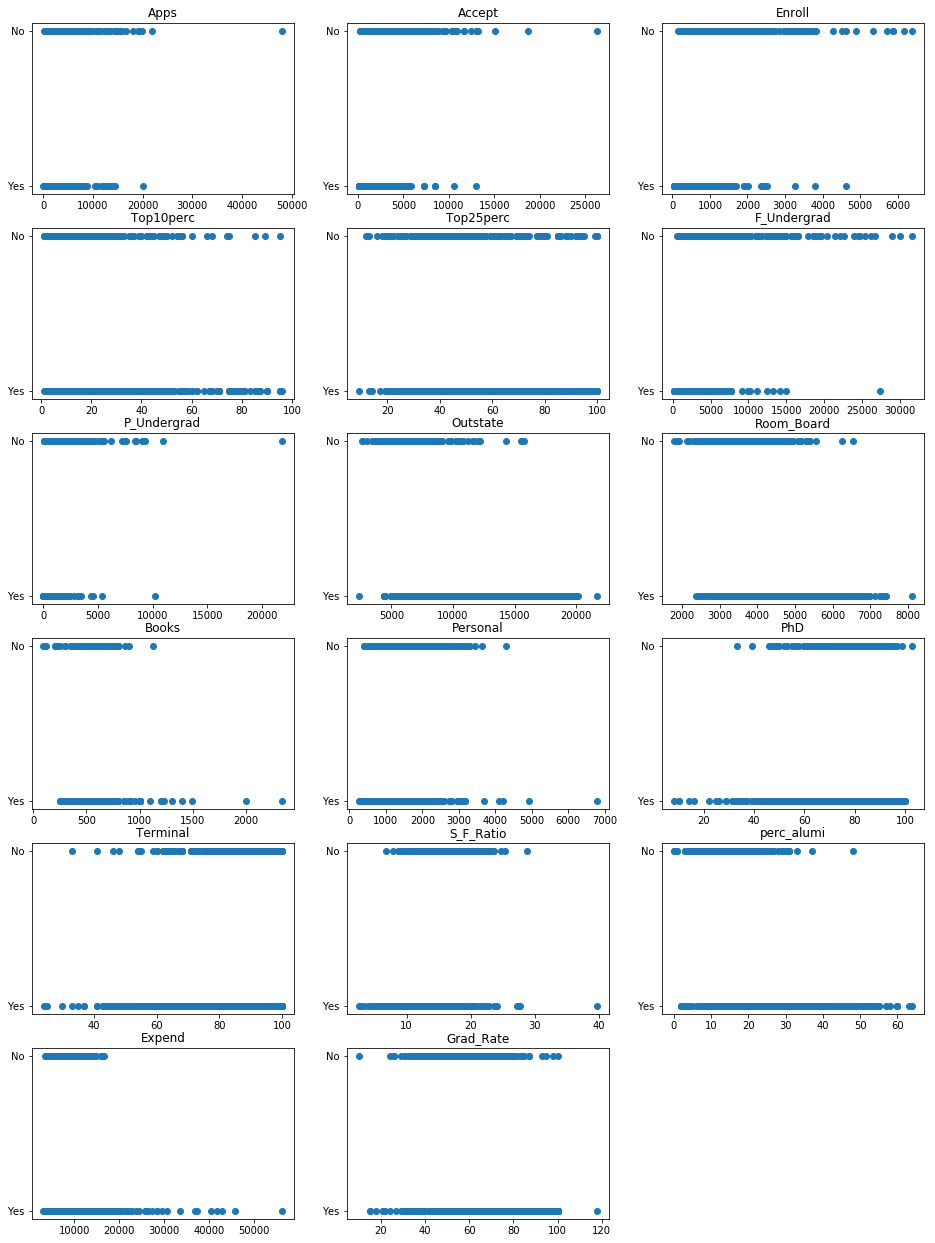

In [46]:
y=pandasDF['Private']
plt.figure(figsize=(16,22))
i=0
for subpo in new_df2.columns:
    x=pandasDF[subpo]
    plt.subplot(6,3,1+i)
    plt.title(subpo)
    plt.scatter(x,y)
    i+=1
plt.show()

## 3 Data preparation

### clean Data

#### 1.Missing value processing of data

In [47]:
remove_Null_Private_DF.na.drop()

DataFrame[Private: string, Apps: bigint, Accept: bigint, Enroll: bigint, Top10perc: bigint, Top25perc: bigint, F_Undergrad: bigint, P_Undergrad: bigint, Outstate: bigint, Room_Board: bigint, Books: bigint, Personal: bigint, PhD: bigint, Terminal: bigint, S_F_Ratio: double, perc_alumi: bigint, Expend: bigint, Grad_Rate: bigint]

#### 2.Delete non-important fields and rebuild the data

In [48]:
remove_Null_Private_DF =remove_Null_Private_DF.drop( 'PhD','perc_alumi','Terminal','Books','Personal','Top10perc','Top25perc')
inputCols=['Apps',
 'Accept',
 'Enroll',
 'F_Undergrad',
 'P_Undergrad',
 'Outstate',
 'Room_Board',
 'S_F_Ratio',
 'Expend',
 'Grad_Rate']
assembler = VectorAssembler(
  inputCols=inputCols,
outputCol="features")
output = assembler.transform(remove_Null_Private_DF)
indexer = StringIndexer(inputCol="Private", outputCol="PrivateIndex")
privateIndex_fixed_DF = indexer.fit(output).transform(output)
privateIndex_fixed_DF.show(8)


+-------+----+------+------+-----------+-----------+--------+----------+---------+------+---------+--------------------+------------+
|Private|Apps|Accept|Enroll|F_Undergrad|P_Undergrad|Outstate|Room_Board|S_F_Ratio|Expend|Grad_Rate|            features|PrivateIndex|
+-------+----+------+------+-----------+-----------+--------+----------+---------+------+---------+--------------------+------------+
|    Yes|1660|  1232|   721|       2885|        537|    7440|      3300|     18.1|  7041|       60|[1660.0,1232.0,72...|         0.0|
|    Yes|2186|  1924|   512|       2683|       1227|   12280|      6450|     12.2| 10527|       56|[2186.0,1924.0,51...|         0.0|
|    Yes|1428|  1097|   336|       1036|         99|   11250|      3750|     12.9|  8735|       54|[1428.0,1097.0,33...|         0.0|
|    Yes| 417|   349|   137|        510|         63|   12960|      5450|      7.7| 19016|       59|[417.0,349.0,137....|         0.0|
|    Yes| 193|   146|    55|        249|        869|    7560| 

异常值处理

查找正常区间

In [49]:

cols =['Apps', 'Accept', 'Enroll', 'F_Undergrad', 'P_Undergrad', 'Outstate', 'Room_Board', 'S_F_Ratio', 'Expend', 'Grad_Rate']
print(cols)
bounds = {}
for col in cols:
    quantiles = remove_Null_Private_DF.approxQuantile(col,[0.05,0.95],0.05)
    IQR = quantiles[1] - quantiles[0]
    if quantiles[0] - 1.5*IQR<0:
        bounds[col] = [
        quantiles[0],
        quantiles[1] + 1.5*IQR
        ]
    else:
        bounds[col] = [
        quantiles[0] - 1.5*IQR,
        quantiles[1] + 1.5*IQR
        ]
print(bounds) 

['Apps', 'Accept', 'Enroll', 'F_Undergrad', 'P_Undergrad', 'Outstate', 'Room_Board', 'S_F_Ratio', 'Expend', 'Grad_Rate']
{'Apps': [81.0, 120113.5], 'Grad_Rate': [10.0, 280.0], 'Expend': [3186.0, 135803.5], 'P_Undergrad': [1.0, 54588.5], 'S_F_Ratio': [2.5, 95.75], 'Room_Board': [1780.0, 17640.0], 'Enroll': [35.0, 15927.5], 'Outstate': [2340.0, 50740.0], 'F_Undergrad': [139.0, 78899.0], 'Accept': [72.0, 65717.0]}


标记异常值

In [50]:
outliers = remove_Null_Private_DF.select([((remove_Null_Private_DF[c] < bounds[c][0]) |(remove_Null_Private_DF[c]>bounds[c][1])).alias(c) for c in cols])
outliers.show(8)

+-----+------+------+-----------+-----------+--------+----------+---------+------+---------+
| Apps|Accept|Enroll|F_Undergrad|P_Undergrad|Outstate|Room_Board|S_F_Ratio|Expend|Grad_Rate|
+-----+------+------+-----------+-----------+--------+----------+---------+------+---------+
|false| false| false|      false|      false|   false|     false|    false| false|    false|
|false| false| false|      false|      false|   false|     false|    false| false|    false|
|false| false| false|      false|      false|   false|     false|    false| false|    false|
|false| false| false|      false|      false|   false|     false|    false| false|    false|
|false| false| false|      false|      false|   false|     false|    false| false|    false|
|false| false| false|      false|      false|   false|     false|    false| false|    false|
|false| false| false|      false|      false|   false|     false|    false| false|    false|
|false| false| false|      false|      false|   false|     false|    f

替换异常值 为最小或最大界限值

In [51]:
from pyspark.sql.functions import *


# print(privateIndex_fixed_DF.toPandas().describe())
privateIndex_pandas_DF=privateIndex_fixed_DF.toPandas().describe()
print(privateIndex_pandas_DF['Apps']['mean'])
print(cols)
for col in cols:
    privateIndex_fixed_DF = privateIndex_fixed_DF.withColumn(col, 
                when(privateIndex_fixed_DF[col] < bounds[col][0],privateIndex_pandas_DF[col]['mean'])
                .when(privateIndex_fixed_DF[col] > bounds[col][1], privateIndex_pandas_DF[col]['mean'])
                .otherwise(privateIndex_fixed_DF[col] ).alias(col))
    print(col+" done")
privateIndex_fixed_DF.show(8)
print(privateIndex_fixed_DF.toPandas().describe())

3001.6383526383524
['Apps', 'Accept', 'Enroll', 'F_Undergrad', 'P_Undergrad', 'Outstate', 'Room_Board', 'S_F_Ratio', 'Expend', 'Grad_Rate']
Apps done
Accept done
Enroll done
F_Undergrad done
P_Undergrad done
Outstate done
Room_Board done
S_F_Ratio done
Expend done
Grad_Rate done
+-------+------+------+------+-----------+-----------+--------+----------+---------+-------+---------+--------------------+------------+
|Private|  Apps|Accept|Enroll|F_Undergrad|P_Undergrad|Outstate|Room_Board|S_F_Ratio| Expend|Grad_Rate|            features|PrivateIndex|
+-------+------+------+------+-----------+-----------+--------+----------+---------+-------+---------+--------------------+------------+
|    Yes|1660.0|1232.0| 721.0|     2885.0|      537.0|  7440.0|    3300.0|     18.1| 7041.0|     60.0|[1660.0,1232.0,72...|         0.0|
|    Yes|2186.0|1924.0| 512.0|     2683.0|     1227.0| 12280.0|    6450.0|     12.2|10527.0|     56.0|[2186.0,1924.0,51...|         0.0|
|    Yes|1428.0|1097.0| 336.0|     

## 4 数据转换

数据LOG 投射

In [52]:
d = {}

for col in cols:
      d[col] = privateIndex_fixed_DF.approxQuantile(col,[0.01,0.99],0.25)

for col in cols:
    privateIndex_fixed_DF = privateIndex_fixed_DF.withColumn(col, log(when(privateIndex_fixed_DF[col] < d[col][0],d[col][0]).when(privateIndex_fixed_DF[col] > d[col][1], d[col][1]).otherwise(privateIndex_fixed_DF[col] ) +1).alias(col))
    print(col+" done")

privateIndex_fixed_DF.show(10)

Apps done
Accept done
Enroll done
F_Undergrad done
P_Undergrad done
Outstate done
Room_Board done
S_F_Ratio done
Expend done
Grad_Rate done
+-------+-----------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+--------------------+------------+
|Private|             Apps|           Accept|            Enroll|       F_Undergrad|       P_Undergrad|         Outstate|       Room_Board|         S_F_Ratio|           Expend|         Grad_Rate|            features|PrivateIndex|
+-------+-----------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+--------------------+------------+
|    Yes|7.415175109613295|7.117205503164344| 6.582025138892826|7.9676267393338165|6.2878585601617845|8.914760527397261|8.101980731853192|2.9496883350525844|8.85964749971499

进行L1 或者L2 正则化 P =1 L1 p=2 L2

In [53]:
# from pyspark.ml.feature import Normalizer
# from pyspark.ml import Pipeline
# vecAssembler = VectorAssembler(inputCols=cols, outputCol="norm_features")
# normalizer = Normalizer(p=1, inputCol="norm_features", outputCol="norm_test")
# pipeline = Pipeline(stages=[vecAssembler, normalizer])
# pipeline_fit = pipeline.fit(privateIndex_fixed_DF)
# normalizer_df = pipeline_fit.transform(privateIndex_fixed_DF)


输出清理后的数据

/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  app.launch_new_instance()


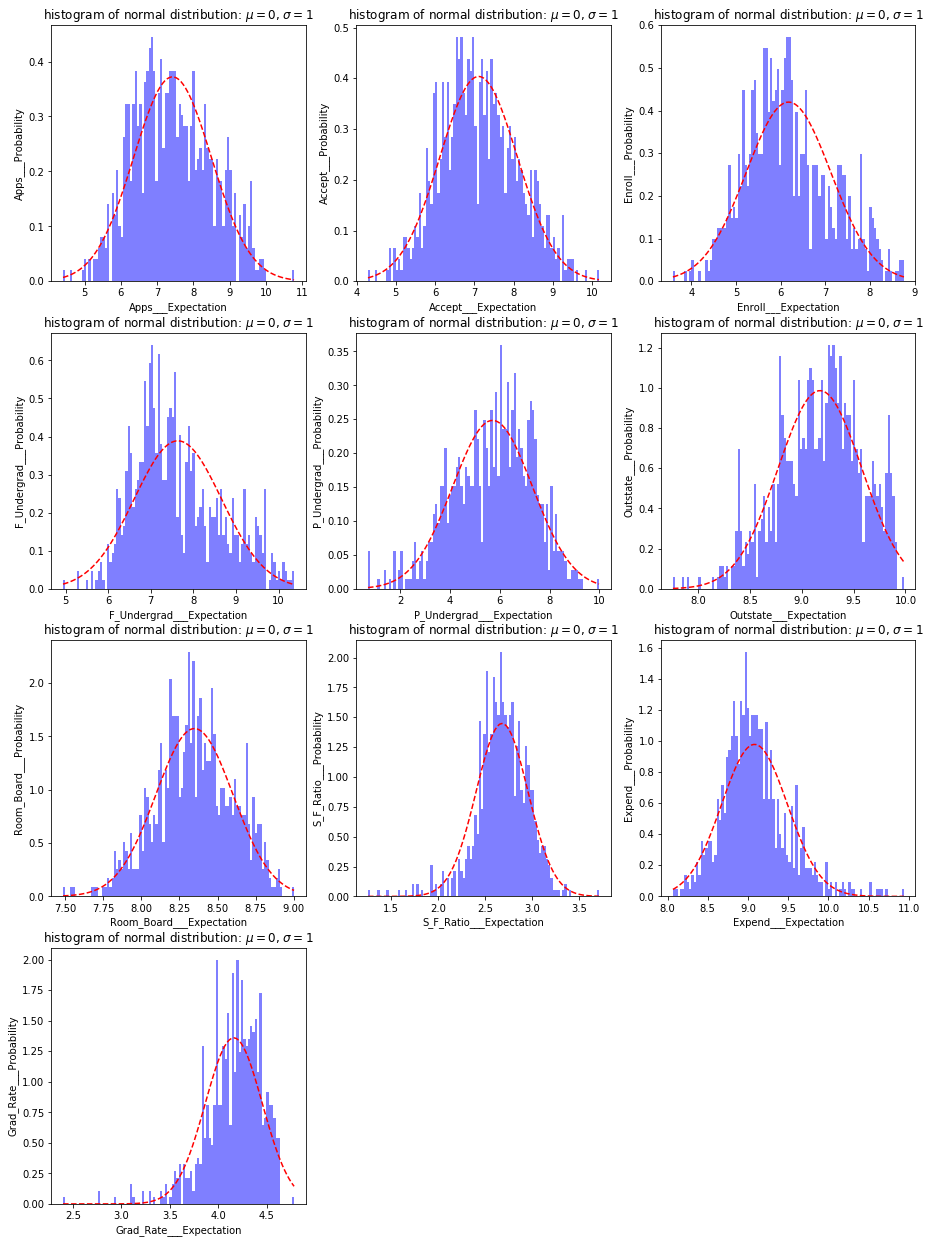

In [54]:
normalizer_df_pd = privateIndex_fixed_DF.select('Private','Apps', 'Accept', 'Enroll', 'F_Undergrad', 'P_Undergrad', 'Outstate', 'Room_Board', 'S_F_Ratio', 'Expend', 'Grad_Rate').toPandas()
expectation_df = normalizer_df_pd.drop('Private',axis=1)
expectation(expectation_df)
normalizer_df_pd.to_csv('/home/ubuntu/BDAS_yang124/Datasets/normalizer_df_pandas.csv')